1. Import Libraries and Load the Dataset

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

print("TensorFlow version:", tf.__version__)

# Load Beans dataset
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1] range
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


TensorFlow version: 2.15.0


2. Define and Compile the Model

In [6]:
# Define the model with leaky_relu activation
model_leaky_relu = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((500, 500, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(125, 125),
    tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
])

def compile_and_train(model, ds_train, ds_test, epochs=10):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])

    history = model.fit(ds_train, validation_data=ds_test, epochs=epochs)
    model.evaluate(ds_test, verbose=2)

    return model, history


3. Train the Model

In [7]:
# Train and evaluate the model
print("Training model")
model_leaky_relu, history = compile_and_train(model_leaky_relu, ds_train, ds_test)


Training model
Epoch 1/10
33/33 [==============================] - 38s 1s/step - loss: 1.8025 - accuracy: 0.4352 - val_loss: 0.9713 - val_accuracy: 0.4453
Epoch 2/10
33/33 [==============================] - 35s 1s/step - loss: 0.8072 - accuracy: 0.6402 - val_loss: 0.9328 - val_accuracy: 0.5156
Epoch 3/10
33/33 [==============================] - 33s 993ms/step - loss: 0.6140 - accuracy: 0.7408 - val_loss: 0.6737 - val_accuracy: 0.6875
Epoch 4/10
33/33 [==============================] - 37s 1s/step - loss: 0.4625 - accuracy: 0.8395 - val_loss: 0.6067 - val_accuracy: 0.7266
Epoch 5/10
33/33 [==============================] - 36s 1s/step - loss: 0.3250 - accuracy: 0.8956 - val_loss: 0.5011 - val_accuracy: 0.8047
Epoch 6/10
33/33 [==============================] - 37s 1s/step - loss: 0.2700 - accuracy: 0.8994 - val_loss: 0.7754 - val_accuracy: 0.7109
Epoch 7/10
33/33 [==============================] - 34s 1s/step - loss: 0.2290 - accuracy: 0.9139 - val_loss: 0.7402 - val_accuracy: 0.7188
Ep

4. Plot Training History

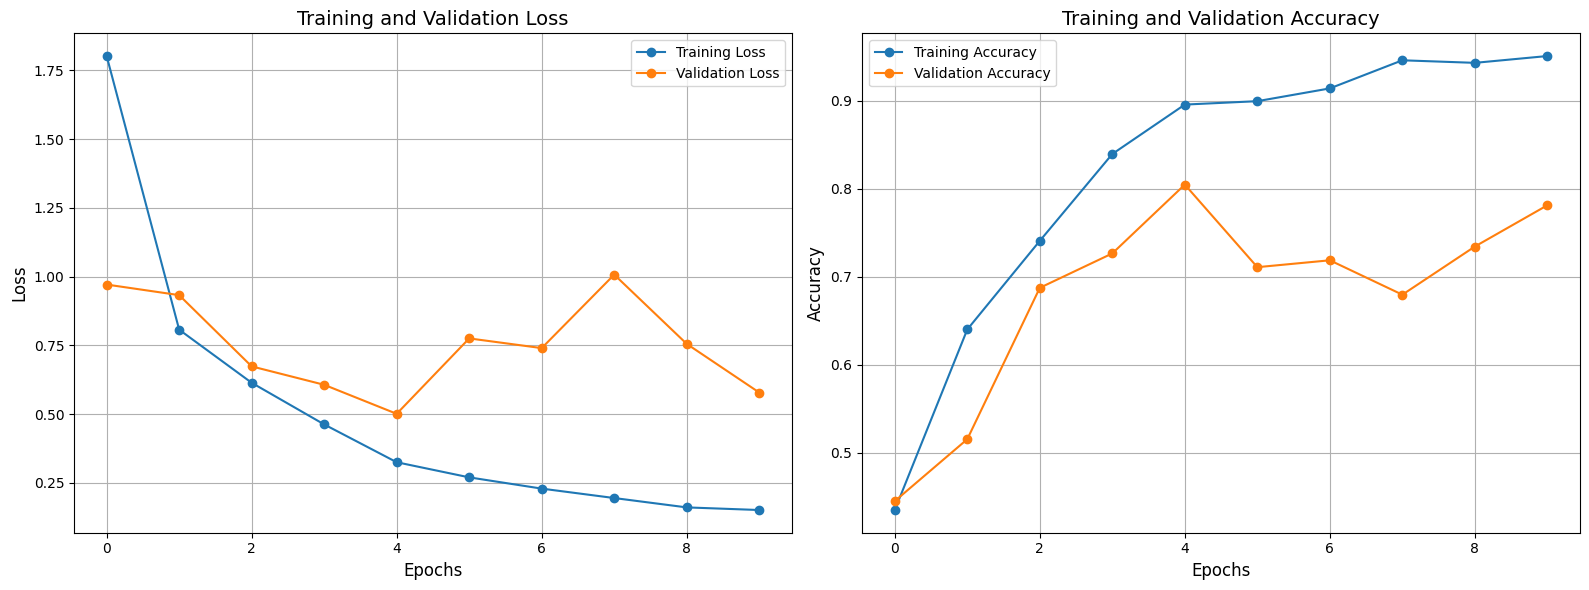

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(16, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


5. Plot Sample Predictions

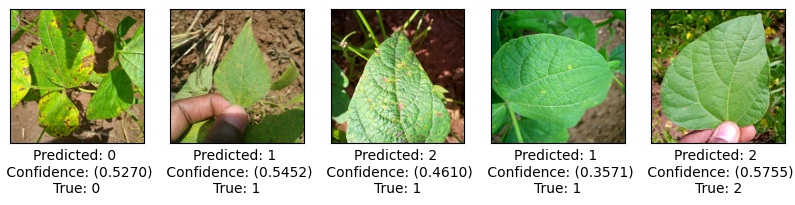

In [11]:
def plot_predictions(model, ds_test, start_point=0):
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    for images, labels in ds_test.take(1):
        predictions = probability_model(images)
        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[start_point + i].numpy())
            plt.xticks([])
            plt.yticks([])
            predicted_label = np.argmax(predictions[start_point + i])
            confidence = predictions[start_point + i][predicted_label].numpy()
            true_label = labels[start_point + i].numpy()
            plt.xlabel(f'Predicted: {predicted_label} \n Confidence: ({confidence:.4f})\nTrue: {true_label}')
        plt.show()

# Plot predictions
plot_predictions(model_leaky_relu, ds_test)


6. Plot Confusion Matrix

1/1 [==============================] - 0s 282ms/step


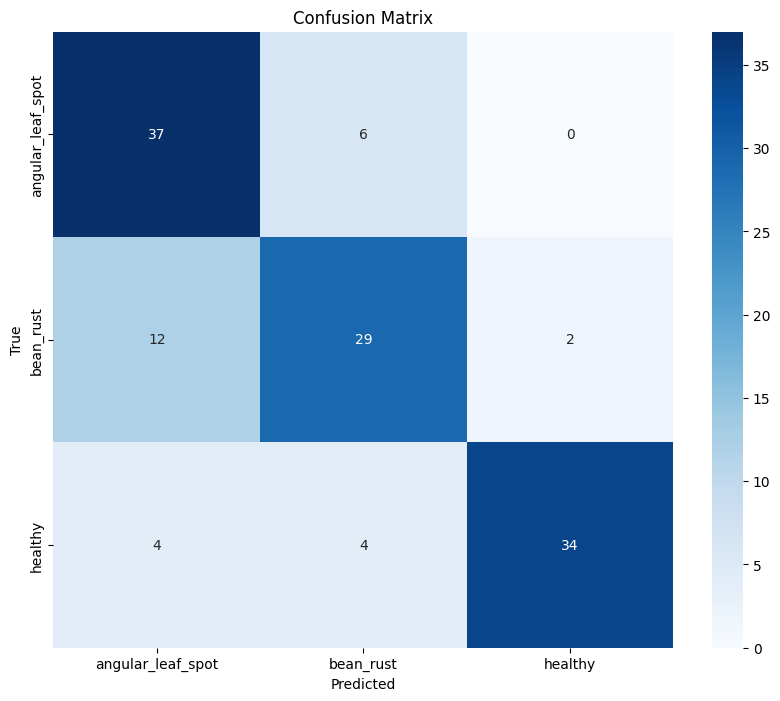

In [10]:
def plot_confusion_matrix(model, ds_test, title):
    y_true = []
    y_pred = []
    for images, labels in ds_test:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=-1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(model_leaky_relu, ds_test, "Confusion Matrix")
